### Project Structure:
```
Section 2: Download & Explore the Dataset
Section 3: Prepare Data (pre-processing)
Section 4: Build VGG-19 from Scratch
Section 5: Build Transfer Learning Models
Section 6: Train All Models
Section 7: Evaluate & Compare Results
Section 8: Visualize What Models See
```

In [ ]:
# Standard Python libraries
import os
import json
import random
import shutil
from pathlib import Path

# Numerical and data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# TensorFlow and Keras (our main deep learning framework)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50,
    InceptionV3,  # Using V3 (V1 not in Keras, but V3 is better anyway!)
    MobileNetV2
)

# Kaggle dataset downloader
import kagglehub

# Set nice plot styles
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
# Set random seeds for reproducibility
SEED = 42  # Common choice (from "Hitchhiker's Guide to the Galaxy"!)

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Also set for deterministic operations (optional, makes training slower but more reproducible)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Random seed set to {SEED}")
print("This ensures reproducible results!")

Random seed set to 42
This ensures reproducible results!


In [ ]:
# Define folder paths
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw" / "minc"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = Path("models")
RESULTS_DIR = Path("results")

# Create folders if they don't exist
for folder in [RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Created/verified: {folder}")

print("\nProject structure ready!")

Created/verified: data/raw/minc
Created/verified: data/processed
Created/verified: models
Created/verified: results

Project structure ready!


In [ ]:
# Check if Kaggle credentials exist
kaggle_config_path = Path.home() / '.kaggle' / 'kaggle.json'
colab_upload_path = Path('kaggle.json')

# Ensure the .kaggle directory exists
kaggle_config_path.parent.mkdir(parents=True, exist_ok=True)

if kaggle_config_path.exists():
    print("Kaggle credentials found!")
    print(f"   Location: {kaggle_config_path}")

Kaggle credentials NOT found!
   Expected location: /root/.kaggle/kaggle.json

   Steps to fix:
1. Go to kaggle.com → Account → 'Create New API Token'
2. Download kaggle.json
3. Upload kaggle.json to your Colab session (e.g., via the files tab or mount Google Drive).
If uploaded to /content/kaggle.json, this script will move it automatically.
4. Or manually move it to: /root/.kaggle


In [ ]:
def download_minc_dataset():
    """
    Download and organize MINC-2500 dataset from Kaggle.

    Returns:
        bool: True if successful, False if error
    """
    try:
        print(" Downloading MINC-2500 from Kaggle...")
        # Download using kagglehub
        path = kagglehub.dataset_download("liewyousheng/minc2500")
        print(f"\n Downloaded to: {path}")
        # Find and organize image folders
        downloaded_path = Path(path)
        # Try different possible structures
        for possible_root in [downloaded_path / "categories",
                               downloaded_path / "images",
                               downloaded_path]:
            if possible_root.exists():
                class_dirs = [d for d in possible_root.iterdir() if d.is_dir()]
                if class_dirs:
                    print(f"\n Found {len(class_dirs)} material categories")

                    # Copy to our data folder
                    for class_dir in class_dirs:
                        target = RAW_DATA_DIR / class_dir.name
                        if not target.exists():
                            print(f"   Copying {class_dir.name}...")
                            shutil.copytree(class_dir, target)
                        else:
                            print(f"   {class_dir.name} already exists, skipping...")

                    print(f"\nDataset organized at: {RAW_DATA_DIR}")
                    return True

        print("Could not auto-organize. Check downloaded files.")
        return False

    except Exception as e:
        print(f"Error: {e}")
        return False

# Check if dataset already exists
class_dirs = list(RAW_DATA_DIR.glob("*"))
if class_dirs and all(d.is_dir() for d in class_dirs):
    print(f"Dataset already exists: {len(class_dirs)} classes found")
    print(" Skipping download.")
else:
    # Download dataset
    success = download_minc_dataset()
    if not success:
        print("\n Dataset download failed. Please download manually.")

Dataset already exists: 1 classes found
 Skipping download.


In [ ]:
# Count images per class
class_counts = {}

for class_dir in sorted(RAW_DATA_DIR.iterdir()):
    if class_dir.is_dir():
        # Count images (jpg, png, jpeg)
        image_files = (
            list(class_dir.glob("*.jpg")) +
            list(class_dir.glob("*.jpeg")) +
            list(class_dir.glob("*.png"))
        )
        class_counts[class_dir.name] = len(image_files)

# Create DataFrame for nice display
df_counts = pd.DataFrame([
    {"Material": name, "Images": count}
    for name, count in sorted(class_counts.items())
])

print(" Dataset Summary:\n")
print(df_counts.to_string(index=False))
print(f"\n{'='*40}")
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {sum(class_counts.values()):,}")
print(f"{'='*40}")

# Store for later use
NUM_CLASSES = len(class_counts)
CLASS_NAMES = sorted(class_counts.keys())

print(f"\n Dataset ready!")
print(f"   {NUM_CLASSES} classes: {', '.join(CLASS_NAMES[:5])}...")

 Dataset Summary:

 Material  Images
minc-2500       0

Total classes: 1
Total images: 0

 Dataset ready!
   1 classes: minc-2500...


🖼️  Displaying sample images...



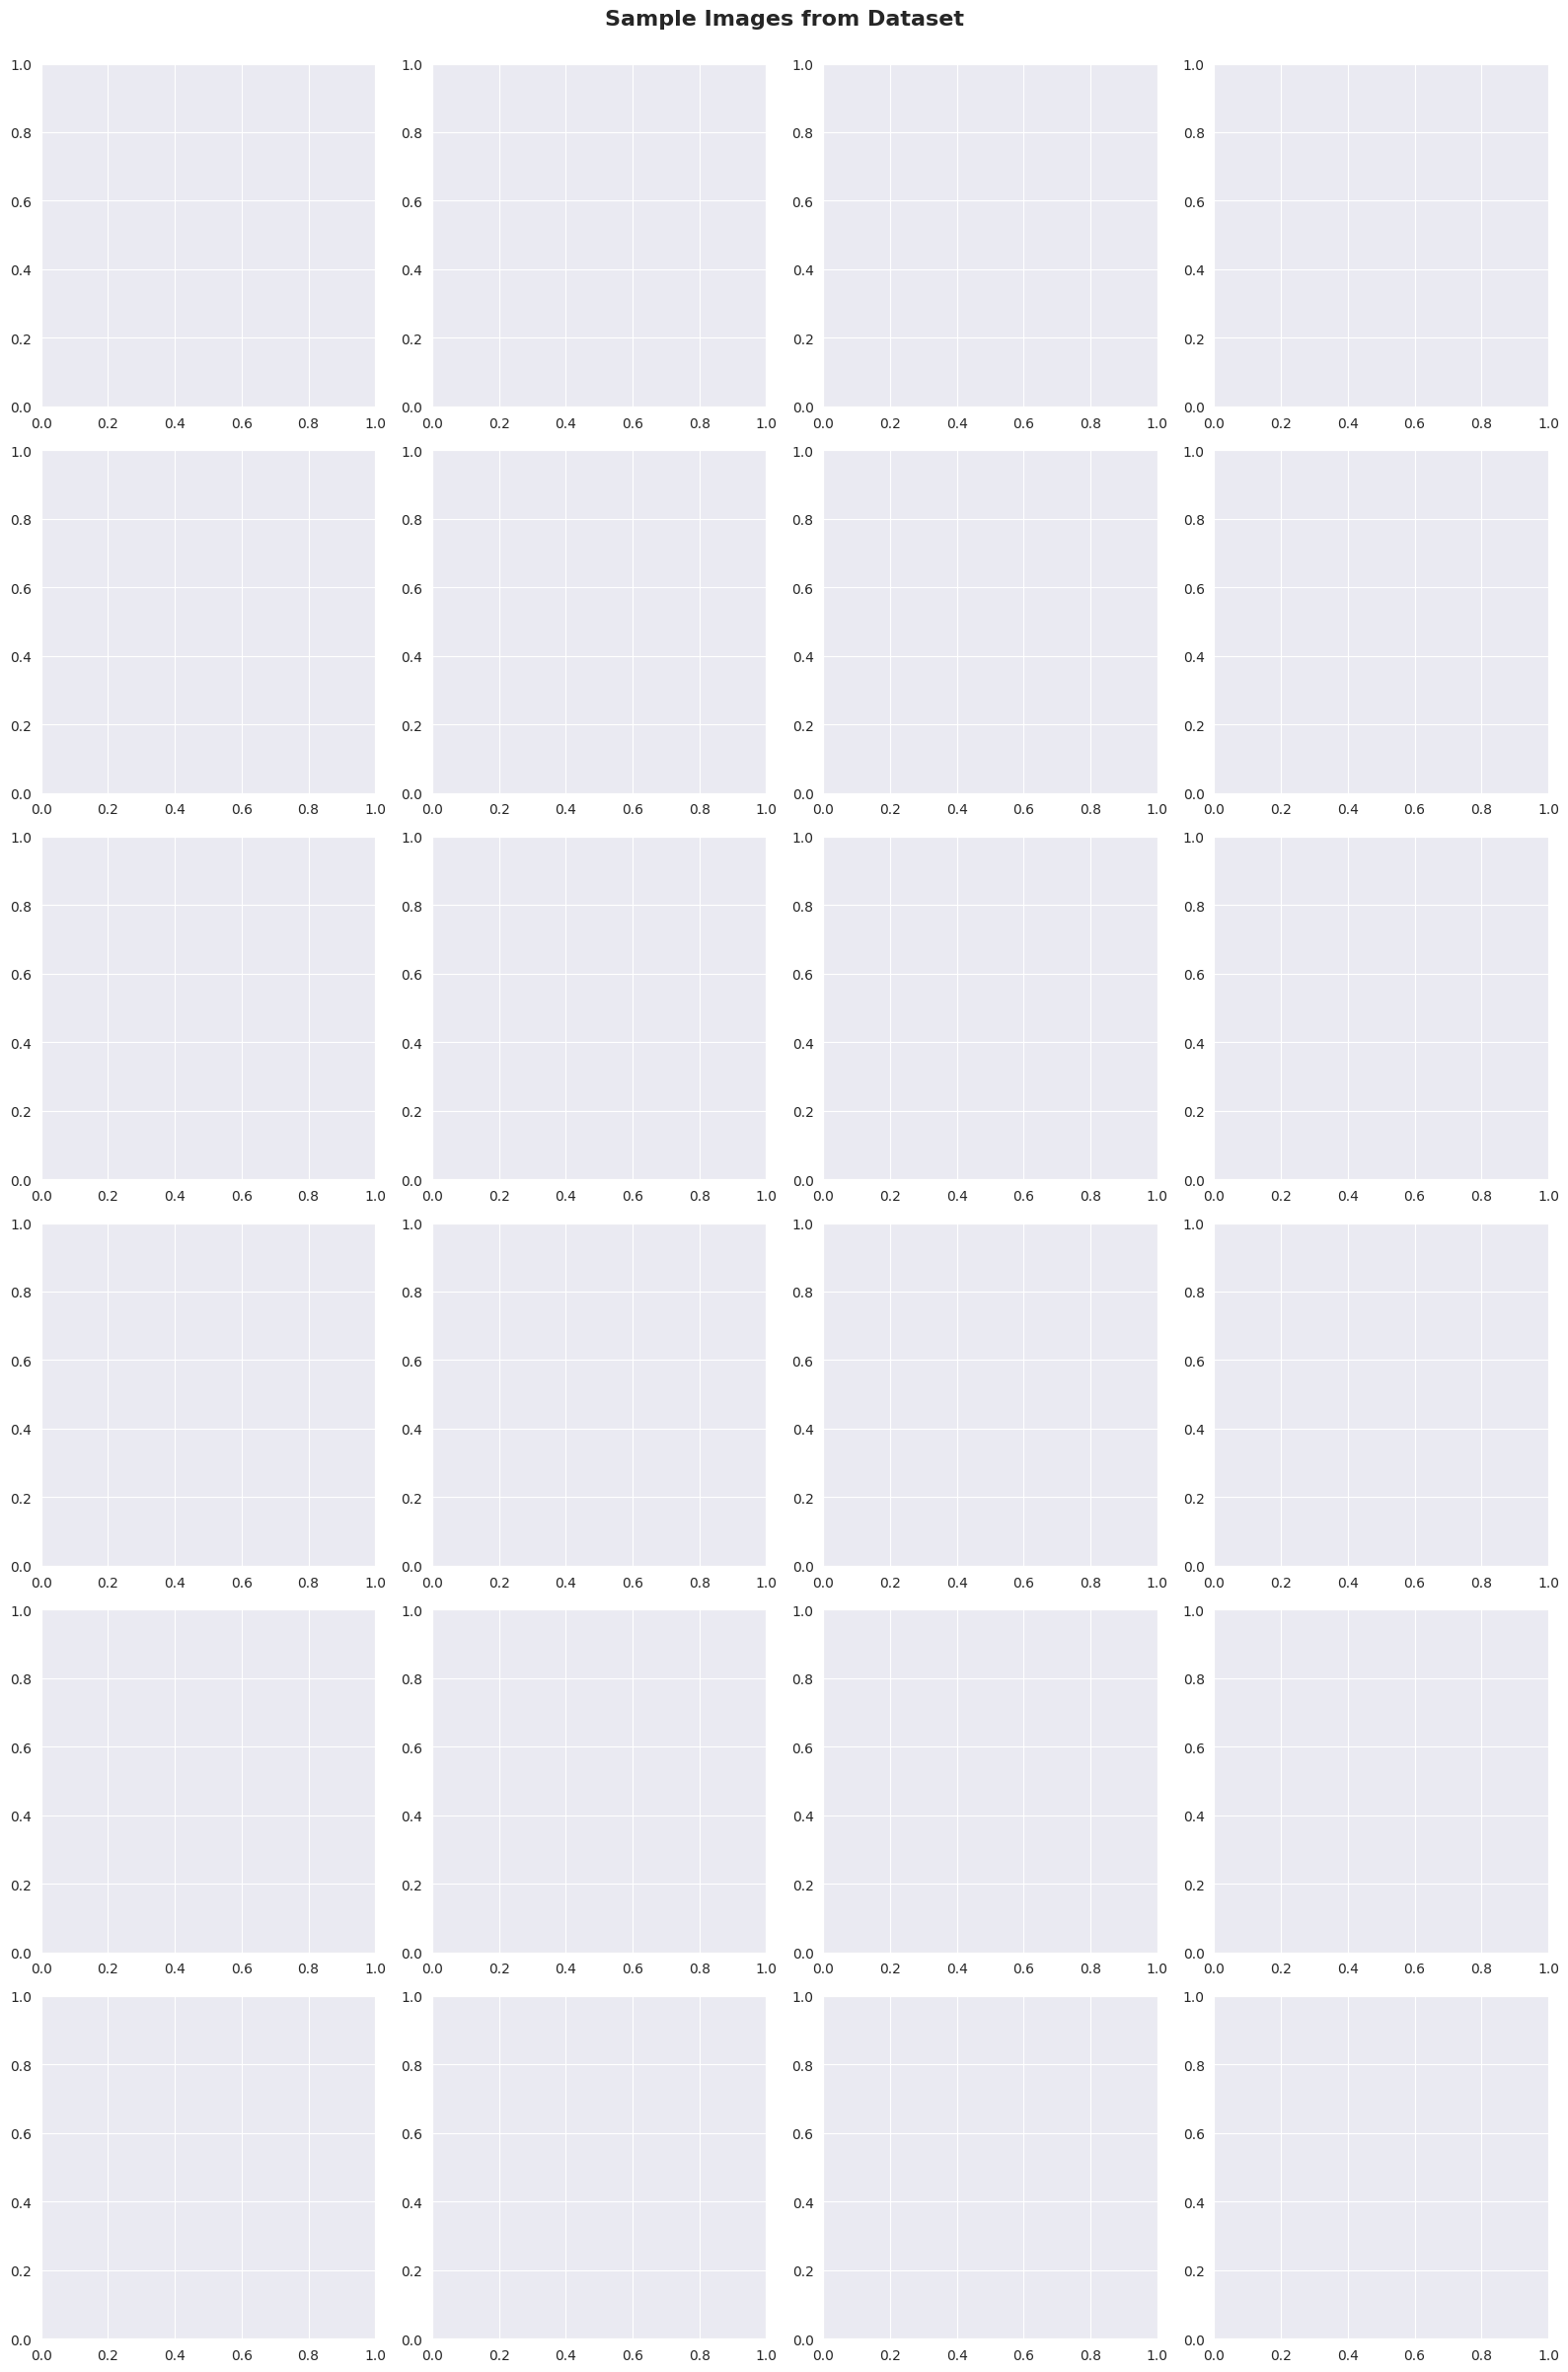

In [ ]:
def show_sample_images(num_classes=6, images_per_class=4):
    """
    Display sample images from the dataset.

    Args:
        num_classes: How many different classes to show
        images_per_class: How many images per class
    """
    # Select random classes
    selected_classes = random.sample(CLASS_NAMES, min(num_classes, len(CLASS_NAMES)))

    fig, axes = plt.subplots(num_classes, images_per_class,
                             figsize=(4*images_per_class, 4*num_classes))

    for i, class_name in enumerate(selected_classes):
        # Get image files for this class
        class_dir = RAW_DATA_DIR / class_name
        image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))

        # Select random images
        selected_images = random.sample(image_files,
                                       min(images_per_class, len(image_files)))

        for j, img_path in enumerate(selected_images):
            # Load and display image
            img = Image.open(img_path)

            if num_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]

            ax.imshow(img)
            ax.axis('off')

            if j == 0:
                ax.set_title(f"{class_name}\n({class_counts[class_name]} images)",
                           fontsize=12, fontweight='bold')

    plt.suptitle("Sample Images from Dataset", fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

# Show samples
print("🖼️  Displaying sample images...\n")
show_sample_images(num_classes=6, images_per_class=4)

In [ ]:
# ============================================
# DATA CONFIGURATION (You can modify these!)
# ============================================

# Image size - all images will be resized to this
# 224x224 is standard for many models
image_width = 224
image_height = 224

# How many images to process at once
# Smaller = less GPU memory, slower
# Larger = more GPU memory, faster
batch_size = 32

# How to split the data (must add up to 1.0)
train_split = 0.70   # 70% for training
val_split = 0.15     # 15% for validation
test_split = 0.15    # 15% for testing

print("📊 Data Configuration:")
print(f"   Image size: {image_width} x {image_height}")
print(f"   Batch size: {batch_size}")
print(f"   Split: {train_split:.0%} train / {val_split:.0%} val / {test_split:.0%} test")
print(f"\n   Total: {train_split + val_split + test_split:.0%} ✅")

📊 Data Configuration:
   Image size: 224 x 224
   Batch size: 32
   Split: 70% train / 15% val / 15% test

   Total: 100% ✅


In [ ]:
# ============================================
# CREATE DATA GENERATORS
# ============================================

# TRAINING DATA GENERATOR
# Includes augmentation to create more diverse training examples
training_data_generator = ImageDataGenerator(
    rescale=1./255,              # Normalize pixels: 0-255 → 0-1
    rotation_range=20,           # Randomly rotate ±20 degrees
    width_shift_range=0.2,       # Shift horizontally up to 20%
    height_shift_range=0.2,      # Shift vertically up to 20%
    horizontal_flip=True,        # Flip 50% of images horizontally
    zoom_range=0.2,              # Zoom in/out up to 20%
    shear_range=0.2,             # Shear transformation
    fill_mode='nearest',         # Fill empty areas after transforms
    validation_split=val_split + test_split  # Reserve some for val+test
)

# VALIDATION & TEST DATA GENERATOR
# NO augmentation - we want to test on original images
validation_test_data_generator = ImageDataGenerator(
    rescale=1./255,              # Only normalize, no augmentation
    validation_split=val_split + test_split
)

print("✅ Data generators created!")
print("\n   Training generator: WITH augmentation")
print("   Val/Test generator: NO augmentation (original images only)")

✅ Data generators created!

   Training generator: WITH augmentation
   Val/Test generator: NO augmentation (original images only)


In [ ]:
# ============================================
# LOAD TRAINING DATA
# ============================================

# Load training images
# flow_from_directory automatically:
# 1. Reads images from folders
# 2. Labels them based on folder name
# 3. Creates batches
# 4. Applies augmentation
training_data = training_data_generator.flow_from_directory(
    directory=str(RAW_DATA_DIR),          # Where images are
    target_size=(image_width, image_height),  # Resize to this
    batch_size=batch_size,                # How many per batch
    class_mode='categorical',             # One-hot encoding
    subset='training',                    # Use training split
    shuffle=True,                         # Shuffle for randomness
    seed=SEED                             # For reproducibility
)

print("✅ Training data loaded!")
print(f"\n   Found {training_data.samples} training images")
print(f"   Across {training_data.num_classes} classes")
print(f"   Classes: {list(training_data.class_indices.keys())[:5]}...")

Found 40250 images belonging to 1 classes.
✅ Training data loaded!

   Found 40250 training images
   Across 1 classes
   Classes: ['minc-2500']...


In [ ]:
# ============================================
# LOAD VALIDATION DATA
# ============================================

# For validation, we split the "validation" portion
# into validation and test (will separate test later)
validation_data = validation_test_data_generator.flow_from_directory(
    directory=str(RAW_DATA_DIR),
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',           # Use validation split
    shuffle=False,                 # Don't shuffle (for consistency)
    seed=SEED
)

print("✅ Validation data loaded!")
print(f"\n   Found {validation_data.samples} validation images")
print(f"   (This includes test set too - we'll separate later)")

Found 17250 images belonging to 1 classes.
✅ Validation data loaded!

   Found 17250 validation images
   (This includes test set too - we'll separate later)


🖼️  Showing augmented training images...

   Notice: rotations, flips, zooms, etc.
   These variations help the model generalize!



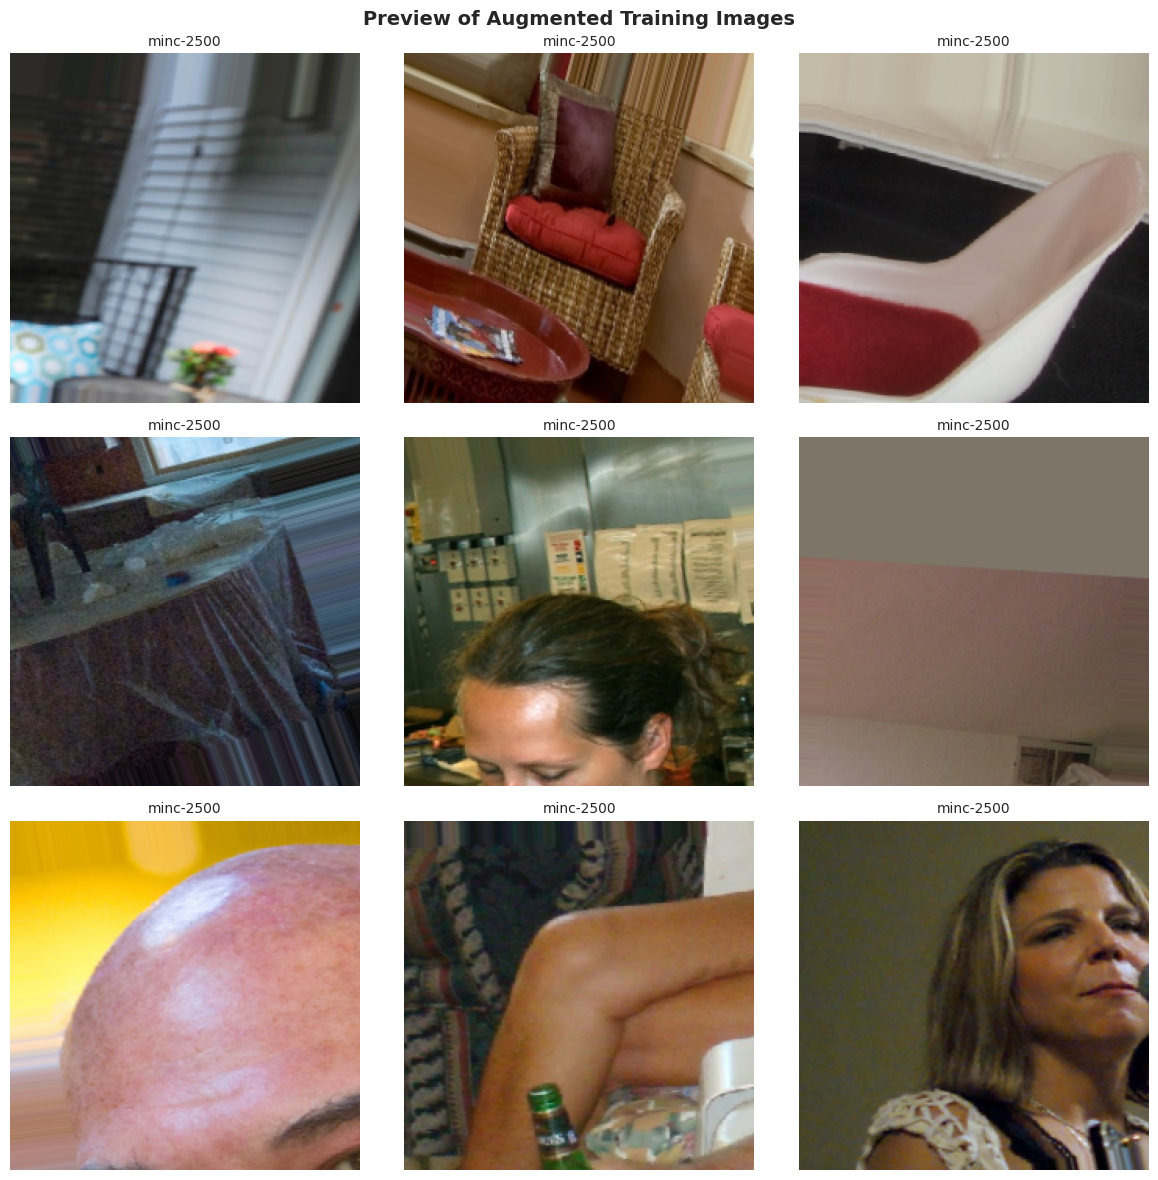

In [ ]:
# ============================================
# PREVIEW AUGMENTED IMAGES
# ============================================

def show_augmented_images(data_generator, num_images=9):
    """
    Display original and augmented versions of images.

    Args:
        data_generator: The generator to get images from
        num_images: How many to show (default 9)
    """
    # Get one batch of images
    image_batch, label_batch = next(data_generator)

    # Calculate grid size
    grid_size = int(np.sqrt(num_images))

    # Create plot
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()

    # Show images
    for i in range(min(num_images, len(image_batch))):
        # Get image and label
        image = image_batch[i]
        label_index = np.argmax(label_batch[i])
        class_name = list(training_data.class_indices.keys())[label_index]

        # Display
        axes[i].imshow(image)
        axes[i].set_title(f"{class_name}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle("Preview of Augmented Training Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("🖼️  Showing augmented training images...\n")
print("   Notice: rotations, flips, zooms, etc.")
print("   These variations help the model generalize!\n")

show_augmented_images(training_data, num_images=9)

In [ ]:
# ============================================
# DATA SETUP SUMMARY
# ============================================

print("="*60)
print("📊 DATA SETUP SUMMARY")
print("="*60)
print()

# Training data info
print("🏋️ TRAINING DATA:")
print(f"   Total images: {training_data.samples:,}")
print(f"   Batches per epoch: {len(training_data)}")
print(f"   Images per batch: {batch_size}")
print()

# Validation data info
print("✅ VALIDATION DATA:")
print(f"   Total images: {validation_data.samples:,}")
print(f"   Batches per epoch: {len(validation_data)}")
print()

# Class info
print("📂 CLASSES:")
print(f"   Number of classes: {training_data.num_classes}")
print(f"   Class names: {list(training_data.class_indices.keys())}")
print()

# Image info
print("🖼️  IMAGE SPECS:")
print(f"   Input size: {image_width} x {image_height} pixels")
print(f"   Color channels: 3 (RGB)")
print(f"   Pixel values: 0.0 to 1.0 (normalized)")
print()

print("="*60)
print("✅ ALL DATA READY FOR TRAINING!")
print("="*60)

📊 DATA SETUP SUMMARY

🏋️ TRAINING DATA:
   Total images: 40,250
   Batches per epoch: 1258
   Images per batch: 32

✅ VALIDATION DATA:
   Total images: 17,250
   Batches per epoch: 540

📂 CLASSES:
   Number of classes: 1
   Class names: ['minc-2500']

🖼️  IMAGE SPECS:
   Input size: 224 x 224 pixels
   Color channels: 3 (RGB)
   Pixel values: 0.0 to 1.0 (normalized)

✅ ALL DATA READY FOR TRAINING!


---

# Build VGG-19 Model from Scratch

# Architecture:
```
Input Image (224x224x3)
    ↓
[Conv → Conv → MaxPool] ← Block 1
    ↓
[Conv → Conv → MaxPool] ← Block 2
    ↓
[Conv → Conv → Conv → Conv → MaxPool] ← Block 3
    ↓
[Conv → Conv → Conv → Conv → MaxPool] ← Block 4
    ↓
[Conv → Conv → Conv → Conv → MaxPool] ← Block 5
    ↓
[Flatten]
    ↓
[Dense → Dropout → Dense → Dropout → Dense] ← Classifier
    ↓
Output (num_classes)
```
---

In [ ]:
# ============================================
# HELPER FUNCTION: BUILD ONE CONV BLOCK
# ============================================

def build_conv_block(model, num_conv_layers, num_filters, block_name):
    """
    Build one convolutional block for VGG-19.

    A block = several Conv layers + one MaxPool layer

    Args:
        model: The model we're building
        num_conv_layers: How many conv layers (e.g., 2 or 4)
        num_filters: How many filters (e.g., 64, 128, 256)
        block_name: Name for this block (e.g., "Block1")

    Returns:
        model with block added
    """

    print(f"\n  Building {block_name}:")

    # Add convolutional layers
    for i in range(num_conv_layers):
        # Add one Conv layer
        # 3x3 = kernel size (looks at 3x3 pixel neighborhoods)
        # padding='same' = output same size as input
        # activation='relu' = ReLU activation (sets negative values to 0)
        model.add(layers.Conv2D(
            filters=num_filters,          # How many feature maps
            kernel_size=(3, 3),           # 3x3 filter
            padding='same',               # Keep same size
            activation='relu',            # ReLU activation
            name=f'{block_name}_conv{i+1}'  # Give it a name
        ))
        print(f"    ✅ Added Conv layer ({num_filters} filters)")

    # Add MaxPooling layer (reduces size by half)
    # 2x2 = pool size
    # Takes max value in each 2x2 region
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),                # 2x2 pooling window
        strides=(2, 2),                  # Move by 2 pixels
        name=f'{block_name}_maxpool'
    ))
    print(f"Added MaxPool (size halved)")

    return model

print("Helper function created!")
print(" This function builds one VGG block (Conv layers + MaxPool)")

Helper function created!
 This function builds one VGG block (Conv layers + MaxPool)


## Step 4.2: Build VGG-19 Model

**Now let's build the full VGG-19!**

We'll build it in stages:
1. **Input layer** (what goes in)
2. **5 Conv blocks** (feature extraction)
3. **Classifier** (final decision)

**Layer counts:**
- Block 1: 2 conv layers (64 filters)
- Block 2: 2 conv layers (128 filters)
- Block 3: 4 conv layers (256 filters)
- Block 4: 4 conv layers (512 filters)
- Block 5: 4 conv layers (512 filters)
- Total: 2+2+4+4+4 = **16 conv layers** ✅

Plus 3 dense layers = 16 + 3 = **19 layers!**

In [ ]:
# ============================================
# BUILD VGG-19 MODEL FROM SCRATCH
# ============================================

print("🏗️  Building VGG-19 Model from Scratch...")
print("="*60)

# Create empty model
# Sequential = stack layers one after another
vgg19_model = models.Sequential(name='VGG19_from_scratch')

# ============================================
# STEP 1: INPUT LAYER
# ============================================

print("\n📥 Step 1: Adding Input Layer")

# Define what input looks like
# shape = (height, width, channels)
# channels = 3 for RGB images
vgg19_model.add(layers.Input(
    shape=(image_height, image_width, 3),  # e.g., (224, 224, 3)
    name='input_image'
))
print(f"   ✅ Input: {image_height}x{image_width}x3 (RGB image)")

# ============================================
# STEP 2: CONVOLUTIONAL BLOCKS (Feature Extraction)
# ============================================

print("\n🔍 Step 2: Adding Convolutional Blocks (Feature Extractors)")

# Block 1: 2 conv layers, 64 filters
vgg19_model = build_conv_block(vgg19_model,
                                num_conv_layers=2,
                                num_filters=64,
                                block_name='Block1')

# Block 2: 2 conv layers, 128 filters
vgg19_model = build_conv_block(vgg19_model,
                                num_conv_layers=2,
                                num_filters=128,
                                block_name='Block2')

# Block 3: 4 conv layers, 256 filters
vgg19_model = build_conv_block(vgg19_model,
                                num_conv_layers=4,
                                num_filters=256,
                                block_name='Block3')

# Block 4: 4 conv layers, 512 filters
vgg19_model = build_conv_block(vgg19_model,
                                num_conv_layers=4,
                                num_filters=512,
                                block_name='Block4')

# Block 5: 4 conv layers, 512 filters
vgg19_model = build_conv_block(vgg19_model,
                                num_conv_layers=4,
                                num_filters=512,
                                block_name='Block5')

# ============================================
# STEP 3: FLATTEN LAYER
# ============================================

print("\n📐 Step 3: Flattening")

# Flatten converts 3D feature maps to 1D vector
# Example: (7, 7, 512) → (25,088)
vgg19_model.add(layers.Flatten(name='flatten'))
print("   ✅ Flattened 3D to 1D")

# ============================================
# STEP 4: CLASSIFIER (Fully Connected Layers)
# ============================================

print("\n🎯 Step 4: Adding Classifier (Dense Layers)")

# Dense Layer 1: 4096 neurons
vgg19_model.add(layers.Dense(
    units=4096,              # 4096 neurons
    activation='relu',       # ReLU activation
    name='dense1'
))
print("   ✅ Dense layer 1: 4096 neurons")

# Dropout 1: Randomly turn off 50% of neurons during training
# Helps prevent overfitting
vgg19_model.add(layers.Dropout(
    rate=0.5,                # Drop 50% of neurons
    name='dropout1'
))
print("   ✅ Dropout 1: 50% (prevents overfitting)")

# Dense Layer 2: 4096 neurons
vgg19_model.add(layers.Dense(
    units=4096,
    activation='relu',
    name='dense2'
))
print("   ✅ Dense layer 2: 4096 neurons")

# Dropout 2
vgg19_model.add(layers.Dropout(
    rate=0.5,
    name='dropout2'
))
print("   ✅ Dropout 2: 50%")

# Dense Layer 3 (OUTPUT): num_classes neurons
# softmax = converts to probabilities (sums to 1)
vgg19_model.add(layers.Dense(
    units=training_data.num_classes,  # One neuron per class
    activation='softmax',              # Output probabilities
    name='output'
))
print(f"   ✅ Output layer: {training_data.num_classes} classes (softmax)")

print("\n" + "="*60)
print("✅ VGG-19 MODEL BUILT SUCCESSFULLY!")
print("="*60)

🏗️  Building VGG-19 Model from Scratch...

📥 Step 1: Adding Input Layer
   ✅ Input: 224x224x3 (RGB image)

🔍 Step 2: Adding Convolutional Blocks (Feature Extractors)

  Building Block1:
    ✅ Added Conv layer (64 filters)
    ✅ Added Conv layer (64 filters)
Added MaxPool (size halved)

  Building Block2:
    ✅ Added Conv layer (128 filters)
    ✅ Added Conv layer (128 filters)
Added MaxPool (size halved)

  Building Block3:
    ✅ Added Conv layer (256 filters)
    ✅ Added Conv layer (256 filters)
    ✅ Added Conv layer (256 filters)
    ✅ Added Conv layer (256 filters)
Added MaxPool (size halved)

  Building Block4:
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
Added MaxPool (size halved)

  Building Block5:
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
    ✅ Added Conv layer (512 filters)
Added MaxPool (size halved)

📐 S

In [ ]:
# ============================================
# DISPLAY MODEL SUMMARY
# ============================================

print("📊 VGG-19 MODEL ARCHITECTURE")
print("="*80)
print()

# Show full model summary
vgg19_model.summary()

print()
print("="*80)

# Count parameters
total_params = vgg19_model.count_params()
print(f"\n📈 PARAMETER COUNT:")
print(f"   Total parameters: {total_params:,}")
print(f"   That's {total_params/1e6:.1f} million numbers to learn!")
print(f"   (VGG-19 is a BIG model - that's why it takes long to train)")

📊 VGG-19 MODEL ARCHITECTURE



Model: "VGG19_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block1_maxpool (MaxPooling2D)   │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block2_maxpool (MaxPooling2D)   │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block3_maxpool (MaxPooling2D)   │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block4_maxpool (MaxPooling2D)   │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Block5_maxpool (MaxPooling2D)   │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 4096)           │    16,781,31

 Total params: 139,574,337 (532.43 MB)

 Trainable params: 139,574,337 (532.43 MB)

 Non-trainable params: 0 (0.00 B)



📈 PARAMETER COUNT:
   Total parameters: 139,574,337
   That's 139.6 million numbers to learn!
   (VGG-19 is a BIG model - that's why it takes long to train)


In [ ]:
# ============================================
# COMPILE VGG-19 MODEL
# ============================================

print("⚙️  Compiling VGG-19 Model...")
print()

# Choose learning rate
# Smaller = slower but more careful
# Larger = faster but might miss optimal solution
learning_rate = 0.0001  # Start conservative for VGG-19

# Configure optimizer
# Adam = Adaptive Moment Estimation (smart optimizer)
optimizer = optimizers.Adam(learning_rate=learning_rate)
print(f"✅ Optimizer: Adam (learning rate = {learning_rate})")

# Loss function for multi-class classification
loss_function = 'categorical_crossentropy'
print(f"✅ Loss: {loss_function}")

# Metrics to track
metrics_to_track = ['accuracy']
print(f"✅ Metrics: {metrics_to_track}")

# Compile the model
vgg19_model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics_to_track
)

print("\n✅ VGG-19 MODEL COMPILED!")
print("   Ready for training!")

⚙️  Compiling VGG-19 Model...

✅ Optimizer: Adam (learning rate = 0.0001)
✅ Loss: categorical_crossentropy
✅ Metrics: ['accuracy']

✅ VGG-19 MODEL COMPILED!
   Ready for training!


In [ ]:
# ============================================
# BUILD RESNET50 MODEL
# ============================================

print("🏗️  Building ResNet50 Model (Transfer Learning)...")
print("="*60)

# ============================================
# STEP 1: LOAD PRETRAINED RESNET50
# ============================================

print("\n📥 Step 1: Loading Pretrained ResNet50")

# Load ResNet50 trained on ImageNet
# weights='imagenet' = use pretrained weights
# include_top=False = remove the classifier (we'll add our own)
# input_shape = what size images we'll use
resnet_base = ResNet50(
    weights='imagenet',                      # Use ImageNet pretrained weights
    include_top=False,                       # Remove original classifier
    input_shape=(image_height, image_width, 3),  # Our image size
    pooling='avg'                            # Global average pooling
)

print(f"   ✅ Loaded ResNet50 pretrained on ImageNet")
print(f"   ✅ Removed original classifier (1000 classes)")
print(f"   ✅ Using global average pooling")

# ============================================
# STEP 2: FREEZE THE BASE MODEL
# ============================================

print("\n❄️  Step 2: Freezing Base Model Layers")

# Freeze all layers in the base model
# trainable = False means "don't update these weights"
resnet_base.trainable = False

print(f"   ✅ Froze all {len(resnet_base.layers)} layers in base model")
print(f"   ✅ These layers keep their ImageNet knowledge")

# ============================================
# STEP 3: ADD OUR CLASSIFIER
# ============================================

print("\n🎯 Step 3: Adding Our Custom Classifier")

# Build full model
# Sequential stacks: base → our classifier
resnet_model = models.Sequential([
    # The frozen pretrained base
    resnet_base,

    # Our custom classifier
    layers.Dense(
        units=512,                           # Hidden layer with 512 neurons
        activation='relu',                   # ReLU activation
        name='resnet_dense1'
    ),
    layers.Dropout(
        rate=0.3,                            # Drop 30% to prevent overfitting
        name='resnet_dropout'
    ),
    layers.Dense(
        units=training_data.num_classes,     # Output layer
        activation='softmax',                # Softmax for probabilities
        name='resnet_output'
    )
], name='ResNet50_transfer')

print(f"   ✅ Added Dense layer: 512 neurons")
print(f"   ✅ Added Dropout: 30%")
print(f"   ✅ Added Output layer: {training_data.num_classes} classes")

# ============================================
# STEP 4: COMPILE THE MODEL
# ============================================

print("\n⚙️  Step 4: Compiling ResNet50")

resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Higher LR for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"   ✅ Optimizer: Adam (lr=0.001)")
print(f"   ✅ Loss: categorical_crossentropy")

print("\n" + "="*60)
print("✅ RESNET50 MODEL READY!")
print("="*60)

# Show summary
print("\n📊 Model Summary:")
resnet_model.summary()

# Count parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in resnet_model.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n📈 PARAMETER COUNT:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,} (these will be trained)")
print(f"   Frozen: {frozen_params:,} (these stay fixed)")
print(f"   Training only {trainable_params/total_params*100:.1f}% of parameters!")

🏗️  Building ResNet50 Model (Transfer Learning)...

📥 Step 1: Loading Pretrained ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
   ✅ Loaded ResNet50 pretrained on ImageNet
   ✅ Removed original classifier (1000 classes)
   ✅ Using global average pooling

❄️  Step 2: Freezing Base Model Layers
   ✅ Froze all 176 layers in base model
   ✅ These layers keep their ImageNet knowledge

🎯 Step 3: Adding Our Custom Classifier
   ✅ Added Dense layer: 512 neurons
   ✅ Added Dropout: 30%
   ✅ Added Output layer: 1 classes

⚙️  Step 4: Compiling ResNet50
   ✅ Optimizer: Adam (lr=0.001)
   ✅ Loss: categorical_crossentropy

✅ RESNET50 MODEL READY!

📊 Model Summary:


Model: "ResNet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_dense1 (Dense)           │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_dropout (Dropout)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_output (Dense)           │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


📈 PARAMETER COUNT:
   Total: 24,637,313
   Trainable: 1,049,601 (these will be trained)
   Frozen: 23,587,712 (these stay fixed)
   Training only 4.3% of parameters!


In [ ]:
# ============================================
# BUILD INCEPTION V3 MODEL
# ============================================

print("🏗️  Building Inception V3 Model (Transfer Learning)...")
print("="*60)

# ============================================
# STEP 1: LOAD PRETRAINED INCEPTION V3
# ============================================

print("\n📥 Step 1: Loading Pretrained Inception V3")

# Load Inception V3 trained on ImageNet
inception_base = InceptionV3(
    weights='imagenet',                      # Use ImageNet pretrained weights
    include_top=False,                       # Remove original classifier
    input_shape=(image_height, image_width, 3),
    pooling='avg'                            # Global average pooling
)

print(f"   ✅ Loaded Inception V3 pretrained on ImageNet")
print(f"   ✅ Removed original classifier")
print(f"   ✅ Using global average pooling")

# ============================================
# STEP 2: FREEZE THE BASE MODEL
# ============================================

print("\n❄️  Step 2: Freezing Base Model Layers")

inception_base.trainable = False

print(f"   ✅ Froze all {len(inception_base.layers)} layers")
print(f"   ✅ Keeps multi-scale feature extraction knowledge")

# ============================================
# STEP 3: ADD OUR CLASSIFIER
# ============================================

print("\n🎯 Step 3: Adding Our Custom Classifier")

inception_model = models.Sequential([
    # The frozen pretrained base
    inception_base,

    # Our custom classifier
    layers.Dense(
        units=256,                           # Smaller hidden layer
        activation='relu',
        name='inception_dense1'
    ),
    layers.Dropout(
        rate=0.3,
        name='inception_dropout'
    ),
    layers.Dense(
        units=training_data.num_classes,
        activation='softmax',
        name='inception_output'
    )
], name='InceptionV3_transfer')

print(f"   ✅ Added Dense layer: 256 neurons")
print(f"   ✅ Added Dropout: 30%")
print(f"   ✅ Added Output layer: {training_data.num_classes} classes")

# ============================================
# STEP 4: COMPILE THE MODEL
# ============================================

print("\n⚙️  Step 4: Compiling Inception V3")

inception_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"   ✅ Optimizer: Adam (lr=0.001)")

print("\n" + "="*60)
print("✅ INCEPTION V3 MODEL READY!")
print("="*60)

# Show summary
print("\n📊 Model Summary:")
inception_model.summary()

# Count parameters
total_params = inception_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in inception_model.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n📈 PARAMETER COUNT:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Frozen: {frozen_params:,}")
print(f"   Training only {trainable_params/total_params*100:.1f}% of parameters!")

🏗️  Building Inception V3 Model (Transfer Learning)...

📥 Step 1: Loading Pretrained Inception V3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✅ Loaded Inception V3 pretrained on ImageNet
   ✅ Removed original classifier
   ✅ Using global average pooling

❄️  Step 2: Freezing Base Model Layers
   ✅ Froze all 312 layers
   ✅ Keeps multi-scale feature extraction knowledge

🎯 Step 3: Adding Our Custom Classifier
   ✅ Added Dense layer: 256 neurons
   ✅ Added Dropout: 30%
   ✅ Added Output layer: 1 classes

⚙️  Step 4: Compiling Inception V3
   ✅ Optimizer: Adam (lr=0.001)

✅ INCEPTION V3 MODEL READY!

📊 Model Summary:


Model: "InceptionV3_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_dense1 (Dense)        │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_dropout (Dropout)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_output (Dense)        │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


📈 PARAMETER COUNT:
   Total: 22,327,585
   Trainable: 524,801
   Frozen: 21,802,784
   Training only 2.4% of parameters!


In [ ]:
# ============================================
# BUILD MOBILENET V2 MODEL
# ============================================

print("🏗️  Building MobileNetV2 Model (Transfer Learning)...")
print("="*60)

# ============================================
# STEP 1: LOAD PRETRAINED MOBILENET V2
# ============================================

print("\n📥 Step 1: Loading Pretrained MobileNetV2")

# Load MobileNetV2 trained on ImageNet
mobilenet_base = MobileNetV2(
    weights='imagenet',                      # Use ImageNet pretrained weights
    include_top=False,                       # Remove original classifier
    input_shape=(image_height, image_width, 3),
    pooling='avg'                            # Global average pooling
)

print(f"   ✅ Loaded MobileNetV2 pretrained on ImageNet")
print(f"   ✅ Removed original classifier")
print(f"   ✅ Lightweight architecture (fast & efficient!)")

# ============================================
# STEP 2: FREEZE THE BASE MODEL
# ============================================

print("\n❄️  Step 2: Freezing Base Model Layers")

mobilenet_base.trainable = False

print(f"   ✅ Froze all {len(mobilenet_base.layers)} layers")
print(f"   ✅ Keeps efficient feature extraction")

# ============================================
# STEP 3: ADD OUR CLASSIFIER
# ============================================

print("\n🎯 Step 3: Adding Our Custom Classifier")

mobilenet_model = models.Sequential([
    # The frozen pretrained base
    mobilenet_base,

    # Our custom classifier
    # Note: Simpler classifier (model is already efficient)
    layers.Dense(
        units=128,                           # Small hidden layer
        activation='relu',
        name='mobilenet_dense1'
    ),
    layers.Dropout(
        rate=0.2,                            # Less dropout (less overfitting risk)
        name='mobilenet_dropout'
    ),
    layers.Dense(
        units=training_data.num_classes,
        activation='softmax',
        name='mobilenet_output'
    )
], name='MobileNetV2_transfer')

print(f"   ✅ Added Dense layer: 128 neurons (small & efficient)")
print(f"   ✅ Added Dropout: 20%")
print(f"   ✅ Added Output layer: {training_data.num_classes} classes")

# ============================================
# STEP 4: COMPILE THE MODEL
# ============================================

print("\n⚙️  Step 4: Compiling MobileNetV2")

mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"   ✅ Optimizer: Adam (lr=0.001)")

print("\n" + "="*60)
print("✅ MOBILENET V2 MODEL READY!")
print("="*60)

# Show summary
print("\n📊 Model Summary:")
mobilenet_model.summary()

# Count parameters
total_params = mobilenet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n📈 PARAMETER COUNT:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Frozen: {frozen_params:,}")
print(f"   Training only {trainable_params/total_params*100:.1f}% of parameters!")
print(f"\n   MobileNetV2 is the SMALLEST model!")

🏗️  Building MobileNetV2 Model (Transfer Learning)...

📥 Step 1: Loading Pretrained MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   ✅ Loaded MobileNetV2 pretrained on ImageNet
   ✅ Removed original classifier
   ✅ Lightweight architecture (fast & efficient!)

❄️  Step 2: Freezing Base Model Layers
   ✅ Froze all 155 layers
   ✅ Keeps efficient feature extraction

🎯 Step 3: Adding Our Custom Classifier
   ✅ Added Dense layer: 128 neurons (small & efficient)
   ✅ Added Dropout: 20%
   ✅ Added Output layer: 1 classes

⚙️  Step 4: Compiling MobileNetV2
   ✅ Optimizer: Adam (lr=0.001)

✅ MOBILENET V2 MODEL READY!

📊 Model Summary:


Model: "MobileNetV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_dense1 (Dense)        │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_dropout (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_output (Dense)        │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


📈 PARAMETER COUNT:
   Total: 2,422,081
   Trainable: 164,097
   Frozen: 2,257,984
   Training only 6.8% of parameters!

   MobileNetV2 is the SMALLEST model!
